<a href="https://colab.research.google.com/github/ghubnerr/machine-learning/blob/main/jax/vae_mnist_jax.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Variational Auto-Encoders in JAX

`Credits: Gabriel Lucchesi` ([GitHub](https://github.com/ghubnerr))

A **Variational Autoencoder (VAE)** is a type of generative model that learns to encode data into a latent representation and then reconstruct data from this latent space. Unlike traditional autoencoders, which directly learn an encoding of the input, VAEs learn **probabilistic** encodings, meaning they learn distributions over possible latent variables. Their probabilistic formulation makes them a powerful and flexible tool for unsupervised representation learning.

*Kingma, D. P., & Welling, M. (2014). Auto-encoding variational Bayes*. In 2nd International Conference on Learning Representations (ICLR).
(Original work published on arXiv in 2013: arXiv:1312.6114)



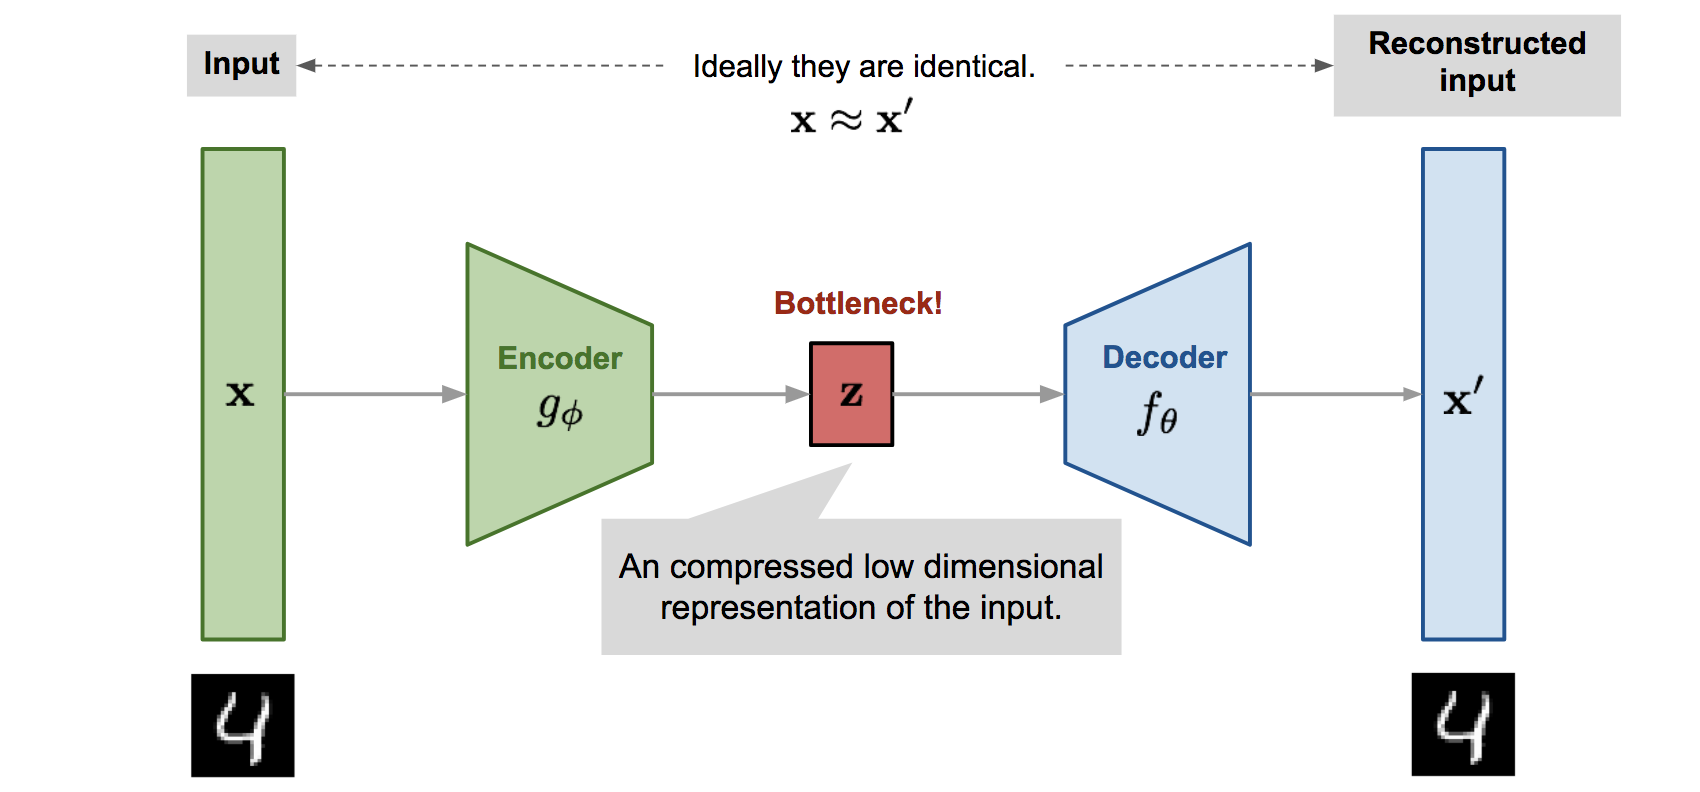



```
@inproceedings{kingma2014auto,
  title={Auto-Encoding Variational Bayes},
  author={Kingma, Diederik P. and Welling, Max},
  booktitle={2nd International Conference on Learning Representations (ICLR)},
  year={2014},
  eprint={1312.6114},
  archivePrefix={arXiv},
  primaryClass={stat.ML}
}
```



In [1]:
import jax
import jax.numpy as jnp
from flax.training.train_state import TrainState
import flax.linen as nn
import optax
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
import tensorflow as tf
from tqdm.autonotebook import tqdm, trange
from functools import partial
from flax.training.common_utils import shard

<ipython-input-1-b43e650c36ce>:10: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


In [2]:
SEED = 0

### Loading MNIST
Binarizing the data allows us to train a VAE with a binary cross entropy loss!

In [3]:

def get_mnist_data():
    ds_builder = tfds.builder('mnist')
    ds_builder.download_and_prepare()
    train_ds = ds_builder.as_dataset(split=f'train')
    test_ds = ds_builder.as_dataset(split=f'test')
    return train_ds, test_ds

def preprocess_data(data):
    images = jnp.array([d['image'] for d in data]) / 255.0
    images = (images > 0.5).astype(jnp.float32)
    labels = jnp.array([d['label'] for d in data])
    return images, labels

In [4]:
train_ds, test_ds = get_mnist_data()

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/mnist/incomplete.IRHNNN_3.0.1/mnist-train.tfrecord*...:   0%|          | 0…

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/mnist/incomplete.IRHNNN_3.0.1/mnist-test.tfrecord*...:   0%|          | 0/…

Dataset mnist downloaded and prepared to /root/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.


In [5]:
train_images, train_labels = preprocess_data(train_ds)
test_images, test_labels = preprocess_data(test_ds)

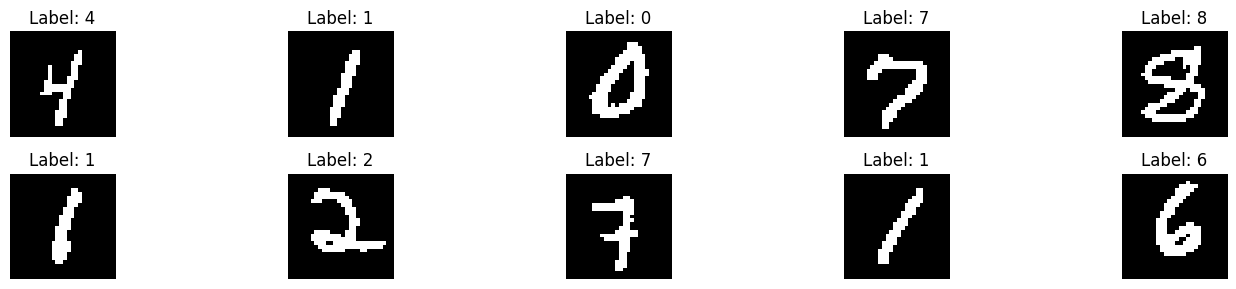

In [6]:
train_images_np = np.array(train_images)

fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(15,3))
axes = axes.flatten()
for i, ax in enumerate(axes):
    ax.imshow(train_images_np[i].squeeze(), cmap='gray')
    ax.set_title(f"Label: {train_labels[i]}")
    ax.axis('off')

plt.tight_layout()
plt.show()

In [7]:
print(train_images[0].shape, print(train_images[0].max()))

1.0
(28, 28, 1) None


## Encoder $\phi$
The Encoder maps an input image $x$ to the parameters (mean $\mu$ and log-variance $\log \sigma^2$) of a latent Gaussian distribution.

$$\mu, \log\sigma^2 = q_\phi(x)$$

this is the approximate posterior distribution:
$$ q_\phi(z|x)= \mathit{N} (z;\mu, \sigma^2I)$$

In [8]:
# q_ɸ(z|x) ~ N(z; μ, σ²I)
class Encoder(nn.Module):
    embedding_dim: int

    @nn.compact
    def __call__(self, x):
        """Encode input images into mean & log-var of latent distribution."""
        # Flatten image: (batch_size, 28, 28, 1) -> (batch_size, 784,)
        x = x.reshape((x.shape[0], -1))

        x = nn.Dense(64)(x)
        x = nn.relu(x)
        x = nn.Dense(32)(x)
        x = nn.relu(x)

        mean = nn.Dense(self.embedding_dim)(x)
        logvar = nn.Dense(self.embedding_dim)(x)

        return mean, logvar

## Decoder $\theta$

The decoder maps a latent vector $z$ back to the space of image.
$$ p_\theta(x|z)$$ In practice, the decoder outputs either the raw image or logits that parameterize a Bernoulli or Gaussian distribution.


In [9]:
class Decoder(nn.Module):
    embedding_dim: int

    @nn.compact
    def __call__(self, z):
        """Decode latent vector z back into an image"""
        x = nn.Dense(32)(z)
        x = nn.relu(x)
        x = nn.Dense(64)(x)
        x = nn.relu(x)

        x = nn.Dense(784)(x)
        x = x.reshape((x.shape[0], 28, 28, 1))

        return x

## Variational Auto-Encoder


### Reparameterization Trick

Instead of sampling directly inside the network:
$$ z \sim N(\mu, \sigma^2I)$$ We use the reparameterization trick to help $\mu$ and $\sigma$ become the **deterministic** outputs of the encoder, and leave the stochasticity to the isolated $\epsilon$, which is independend of the encoder parameters. This makes the gradient flow through $\mu$ and $\sigma$ feasible via standard backg
$$ z = \mu + \sigma \odot \epsilon, \quad \epsilon \sim N(0,I)$$

- $z$: (latent_dim,)
- $x$: (input_dim,)
- $\mu$: (embedding_dim,)
- $\sigma$: (embedding_dim, )
- $\hat x$: (output_dim,)
- $\epsilon$: (embedding_dim,)
- $N(0,I)$: (embedding_dim, ) - Sampled for each dimension in the embedding space

However, we can use an average over $\epsilon_1$ and $\epsilon_2$ for better performance

In [10]:
class VAE(nn.Module):
    embedding_dim: int

    def setup(self):
        self.encoder = Encoder(self.embedding_dim)
        self.decoder = Decoder(self.embedding_dim)

    def reparameterize(self, rng, mean, logvar):
        """Reparameterization trick to sample z from q(z|x)"""

        std = jnp.exp(0.5 * logvar)
        # z = μ + σ * ε, ε ~ Ν(0, I)
        eps = jax.random.normal(rng, shape=logvar.shape)
        z = mean + std * eps

        return z

    def __call__(self, x, rng):
        """Forward pass, encode, sample then decode"""
        mean, logvar = self.encoder(x) # μ, σ
        z = self.reparameterize(rng, mean, logvar)
        x_hat = self.decoder(z)

        return x_hat, mean, logvar

    def decode(self, z):
        """Given a latent sample z, return a decoded output."""
        return self.decoder(z)

## VAE Loss Function

### ELBO (Evidence Lower BOund)
This optimizes VAE and is composed of two parts: the reconstruction loss and the KL divergence. We basically call this the Evidence Lower Bound because it provides a lower bound on the marginal likelihood over the data. The term "evidence" refer the probability of the data under the model, which is difficult to compute directly and is intractible. The ELBO provides a close approximation to it, so if we maximize the ELBO, we can basically get a closer distribution to the prior.

$$ L(\theta, \phi; x)=\mathbb{E}_{q_\phi(z|x)}[\log p_\theta(x|z)]-D_{KL}(q_\phi(z|x)||p(z)) $$

Which makes the VAE Loss that we have to minimize:
$$VAE_{loss}=-L = - \mathbb{E}_{q_\phi(z|x)}[\log p_\theta(x|z)] + D_{KL}(q_\phi(z|x)||p(z))
$$

- **Reconstruction Loss**: Quantifies how well the decoder can reconstruct the original image given the latent vector. We use cross-entropy on the pixel values to make sure they get as close as possible from the original input since our data is likely treated as binary $\{0,1\}$ for MNIST.
$$ -\sum_i[x_i \log(\hat x_i) + (1 - x_i)\log(1-\hat x_i)]$$

- **KL Divergence**: Measures how one probability distribution differs from another (the posterior $q_\phi(z|x)$ vs the prior $p(z$)). Since we assume that the prior distribution is gaussian, the KL divergence provides itself as a **closed form** solution.
$$ D_{KL} (N(\mu, \sigma^2)|| N(0,I))=\frac12\sum_j(\sigma_j^2 + \mu_j^2-1 -\log\sigma_j^2)$$
Which rearranges to:
$$-\frac12\sum_j(1 + \sigma_j^2 - \mu_j^2 +\log\sigma_j^2)$$

In [11]:
def vae_loss(x_hat, x, mean, logvar):
    x = x.reshape(-1, 784)
    x_hat = x_hat.reshape(-1, 784)

    reconstruction_loss = optax.sigmoid_binary_cross_entropy(x_hat, x).sum()
    kl_divergence = -0.5 * jnp.sum(1 + logvar - jnp.square(mean) - jnp.exp(logvar))

    total_loss = reconstruction_loss + kl_divergence # -ELBO

    return total_loss, reconstruction_loss, kl_divergence

## Training

In [12]:
LEARNING_RATE = 1e-3
BATCH_SIZE = 64
NUM_EPOCHS = 20
EMBEDDING_DIM = 128

In [13]:
rng = jax.random.PRNGKey(SEED)
rng, init_rng = jax.random.split(rng)

In [14]:
vae = VAE(EMBEDDING_DIM)
params = vae.init(init_rng, jnp.ones((BATCH_SIZE, 28, 28, 1)), rng)

In [15]:
optimizer = optax.adam(LEARNING_RATE)
opt_state = optimizer.init(params)

In [16]:
@jax.jit
def update_fn(params, opt_state, x, rng):
    def loss_fn(params):
        x_hat, mean, logvar = vae.apply(params, x, rng)
        total_loss, recon_loss, kl_loss = vae_loss(x_hat, x, mean, logvar)
        return total_loss, (recon_loss, kl_loss)

    (total_loss, (recon_loss, kl_loss)), grads = jax.value_and_grad(loss_fn, has_aux=True)(params)
    updates, opt_state = optimizer.update(grads, opt_state, params)
    params = optax.apply_updates(params, updates)

    return params, opt_state, total_loss, recon_loss, kl_loss


In [17]:
def data_loader(images, batch_size):
    num_batches = len(images) // batch_size
    for i in range(num_batches):
        yield images[i * batch_size:(i + 1) * batch_size]

In [18]:
metrics = {
    'total_loss': [],
    'reconstruction_loss': [],
    'kl_loss': []
}

In [19]:
for epoch in trange(NUM_EPOCHS):
    rng, epoch_rng = jax.random.split(rng)
    epoch_loss = 0

    for batch in data_loader(train_images, BATCH_SIZE):
        rng, batch_rng = jax.random.split(rng)
        params, opt_state, total_loss, recon_loss, kl_loss = update_fn(params, opt_state, batch, batch_rng)

        b_size = batch.shape[0]

        # Per-example loss
        metrics['total_loss'].append(total_loss / b_size)
        metrics['reconstruction_loss'].append(recon_loss / b_size)
        metrics['kl_loss'].append(kl_loss / b_size)
        epoch_loss += total_loss

    elbo = -epoch_loss / len(train_images)
    if epoch % 5 == 0:
        print(f"Epoch {epoch}, ELBO: {elbo}")

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 0, ELBO: -204.71054077148438
Epoch 5, ELBO: -121.31156921386719
Epoch 10, ELBO: -110.98291015625
Epoch 15, ELBO: -107.48004913330078


In [20]:
@jax.jit
def val_loss(params, batch, rng):
    x_hat, mean, logvar = vae.apply(params, batch, rng)
    total_loss, recon_loss, kl_loss = vae_loss(x_hat, batch, mean, logvar)
    return total_loss

In [21]:

test_loss = 0
for batch in data_loader(test_images, BATCH_SIZE):
    rng, batch_rng = jax.random.split(rng)
    batch_loss =  val_loss(params, batch, batch_rng)
    test_loss += batch_loss

avg_test_loss = test_loss / len(test_images)
print(f"Validation Loss: {-avg_test_loss}")

Validation Loss: -104.7554702758789


## Sampling from a latent Gaussian Distribution

In [22]:
def sample_vae(params, rng, num_samples, embedding_dim):
    z = jax.random.normal(rng, shape=(num_samples, embedding_dim))
    decoded_samples = vae.apply(params, z, method=vae.decode)
    return decoded_samples

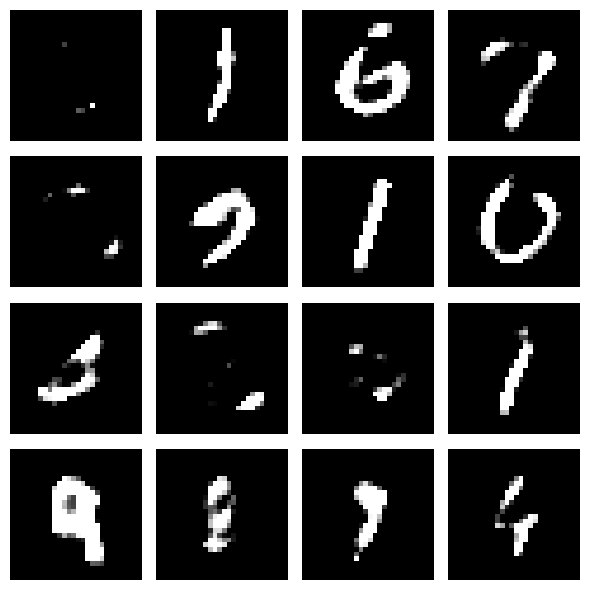

In [23]:
rng, sample_rng = jax.random.split(rng)
num_samples = 16

samples = sample_vae(params, sample_rng, num_samples, embedding_dim=vae.embedding_dim)

samples = jnp.clip(samples, 0, 1)
samples = np.asarray(samples)

fig, axes = plt.subplots(4, 4, figsize=(6, 6))
for i, ax in enumerate(axes.flat):
    ax.imshow(samples[i].squeeze(), cmap="gray")
    ax.axis('off')

plt.tight_layout()
plt.show()


# Visualization

Here, the loss is in the hundreds due to the way it is computed and how often during the training

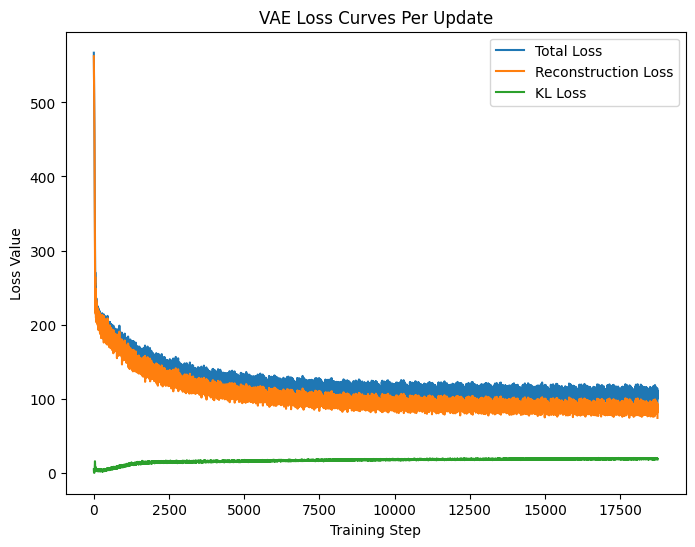

In [24]:
steps = range(len(metrics['total_loss']))

plt.figure(figsize=(8, 6))
plt.plot(steps, metrics['total_loss'], label='Total Loss')
plt.plot(steps, metrics['reconstruction_loss'], label='Reconstruction Loss')
plt.plot(steps, metrics['kl_loss'], label='KL Loss')

plt.xlabel('Training Step')
plt.ylabel('Loss Value')
plt.title('VAE Loss Curves Per Update')
plt.legend()
plt.show()